In [1]:
import pickle
import json 
import os
import matplotlib.pyplot as plt
from SoccerNet.utils import getListGames

In [2]:
# pickle to results format
def process_results(data):
    vidxs = sorted(list(set(data['video-id'])))
    results_dict = {}
    for vidx in vidxs:
        results_dict[vidx] = []

    for vidx, start, end, label, score in zip(
            data['video-id'],
            data['t-start'],
            data['t-end'],
            data['label'],
            data['score']
        ):
            results_dict[vidx].append(
                {
                    "label" : int(label),
                    "score" : float(score),
                    "segment": [float(start), float(end)],
                }
            )
    return results_dict

In [3]:
#get gt labels filename
def get_gt_labels(game):
    temp = game.split("/")[:-1]
    replacement = temp[-1].replace("_", " ")
    temp[-1] = replacement
    file = "/home/csgrad/akumar58/soccernet/spotting_data/spotting_video/" + "/".join(temp)+"/Labels-v2.json"
    return file

#get pred and gt data
def get_data(results_dict, checkfile):
    pred_data = []
    gt_data = []
    temp = checkfile.split("/")[:-1]
    file = (temp[-1].replace(" ","_"))
    temp[-1] = file
    pred_file = "AA".join(temp)
    halfs = ["1_baidu_soccer_embeddings_", "2_baidu_soccer_embeddings_"]
    splits = ["train", "test", "val"]
    h = True
    for half in halfs:
        for split in splits:
            name = pred_file+"AA"+half+split
            if name in results_dict:
                for annot in results_dict[name]:
                    pred_data.append(annot)
                if h:
                    print("Found 1st half")
                    h = False
                else:
                    print("Found 2nd half")

                #read gt label here
                game = name.split("224p")[0][:-4]
                game = game.replace("AA","/")
                assert "GT file exists " ,os.path.exists(get_gt_labels(game))
                if not gt_data:
                    f = open(get_gt_labels(game))
                    gt_data = json.load(f)
                    print("GT data loaded")
                else:
                    print("GT data already loaded")
    return pred_data, gt_data                                          

In [4]:
# Create timeline plot
def makeplot(pred, gt, ranges, delta, align='center'):
    label2idx = {
    "Penalty":0,"Kick-off":1,"Goal":2,"Substitution":3,"Offside":4,"Shots on target":5,
                                "Shots off target":6,"Clearance":7,"Ball out of play":8,"Throw-in":9,"Foul":10,
                                "Indirect free-kick":11,"Direct free-kick":12,"Corner":13,"Yellow card":14
                                ,"Red card":15,"Yellow->red card":16}

    actions = [action for action, idx in label2idx.items()]

    pred_start_times = [[] for i in range(17)]
    pred_end_times = [[] for i in range(17)]
    pred_scores = [[] for i in range(17)]

    gt_start_times = [[] for i in range(17)]
    gt_end_times = [[] for i in range(17)]

    for annot in pred:
        label = annot['label']
        pred_start_times[label].append(annot['segment'][0])
        pred_end_times[label].append(annot['segment'][1])
        pred_scores[label].append(annot['score'])


    for annot in gt['annotations']:
        label = label2idx[annot['label']]
        time = int(annot['position'])//(1000)
        if align == 'center':
            gt_start_times[label].append(time-delta/2)
            gt_end_times[label].append(time+delta/2)
        else:
            gt_start_times[label].append(time)
            gt_end_times[label].append(time+delta)

    fig, ax = plt.subplots()
    # GT
    for i in range(len(actions)):
        for j in range(len(gt_start_times[i])):
            ax.broken_barh([(gt_start_times[i][j], gt_end_times[i][j]-gt_start_times[i][j])], (i+0.1, 0.5), facecolors='blue', alpha=1.0)
    
    #Preds
    for i in range(len(actions)):
        for j in range(len(pred_start_times[i])):
            ax.broken_barh([(pred_start_times[i][j], pred_end_times[i][j]-pred_start_times[i][j])], (i+0.1, 0.8), facecolors='red', alpha=pred_scores[i]) 

    st, en = ranges
    ax.set_ylim(0, len(actions))
    ax.set_xlim(st, en)
    ax.set_xlabel('Gametime (s)')
    ax.set_yticks(range(len(actions)))
    ax.set_yticklabels(actions)

    ax.grid(True)
    plt.show()

In [5]:
## get list of test file names
# testgames = getListGames('test')
# testgames

In [8]:
pkl_path = '/home/csgrad/mbhosale/SoccerNet-Action-Spotting/ckpt_wt_bd_regloss_no_sf/soccernet_baidu_reproduce/eval_results_e10_wt_pp.pkl'
testgame = 'germany_bundesliga/2016-2017/2016-11-19 - 20-30 Dortmund 1 - 0 Bayern Munich/'

with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

results_dict = process_results(data)
pred, gt = get_data(results_dict, testgame)

Found 1st half
GT data loaded
Found 2nd half
GT data already loaded


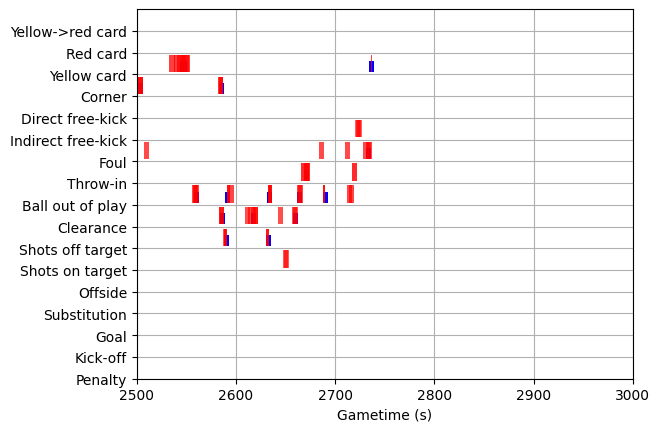

In [9]:
ranges = (2500, 3000)
gt_delta = 5
makeplot(pred, gt, ranges, gt_delta, align='center')